this notebook is working on:
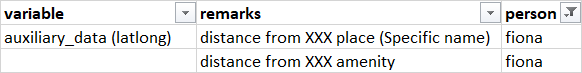

In [1]:
import pandas as pd
import numpy as np
import os, re, random
import warnings, json
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from collections import Counter, defaultdict
from datetime import datetime
dates_dict = {
    'B_birthday': '%Y-%m-%d', 
    'B_dtopentime': '%Y-%m-%d %H:%M:%S'
}

current_folder = os.path.abspath(os.curdir)
root_folder = os.path.dirname(current_folder) 
data_folder = os.path.join(root_folder,'data')
%matplotlib inline

def set_seeds(seed):
    # for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
set_seeds(1234)

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [2]:
train_df = pd.read_csv(os.path.join(data_folder,'train.csv'))
# test_df = pd.read_csv(os.path.join(data_folder,'test.csv'))
train_df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'eco_category', 'lease_commence_date',
       'latitude', 'longitude', 'elevation', 'subzone', 'planning_area',
       'region', 'resale_price'],
      dtype='object')

In [45]:
auxiliary_paths = {
    'commercial':'sg-commerical-centres.csv',
    'hawker': 'sg-gov-markets-hawker-centres.csv',
#     'demographics': 'sg-population-demographics.csv',
    'prisch': 'sg-primary-schools.csv',
    'secsch': 'sg-secondary-schools.csv',
    'malls': 'sg-shopping-malls.csv',
    'station': 'sg-train-stations.csv'
}

In [46]:
aux_df = defaultdict(pd.DataFrame)
for aux in auxiliary_paths.keys():
    print(f'Opening auxiliary data bout "{aux}"...')
    aux_df[aux] = pd.read_csv(os.path.join(os.path.join(data_folder, 'auxiliary-data'), auxiliary_paths[aux]))
    print(aux_df[aux].head(20))
    print('')

Opening auxiliary data bout "commercial"...
                            name  type       lat         lng
0      Central Business District    CR  1.286768  103.854529
1           Jurong Lake District    CR  1.334085  103.734513
2        Seletar Regional Centre    CR  1.409435  103.866820
3       Tampines Regional Centre    CR  1.353180  103.945188
4      Woodlands Regional Centre    CR  1.436748  103.786485
5         Airport Logistics Park  IEBP  1.375856  104.002617
6           Changi Aviation Park  IEBP  1.368803  104.001026
7           Changi Business Park  IEBP  1.335123  103.965127
8           Defu Industrial Park  IEPB  1.355457  103.895074
9    International Business Park  IEBP  1.327911  103.747405
10      Jurong Industrial Estate  IEBP  1.325451  103.695421
11    Jurong Innovation District  IEBP  1.353293  103.694896
12  Lorong Halus Industrial Park  IEBP  1.375386  103.902112
13      Loyang Industrial Estate  IEBP  1.383452  103.974425
14                     one-north  IEBP  1

In [5]:
def Haversine(lat1,lon1,lat2,lon2,roundoff=4):
    """
    Code Source: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
    
    This uses the ‘haversine’ formula to calculate the great-circle distance between two points – that is, 
    the shortest distance over the earth’s surface – giving an ‘as-the-crow-flies’ distance between the points 
    (ignoring any hills they fly over, of course!).
    Haversine
    formula:    a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
    c = 2 ⋅ atan2( √a, √(1−a) )
    d = R ⋅ c
    where   φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
    note that angles need to be in radians to pass to trig functions!
    """
    R = 6371.0088
    lat1,lon1,lat2,lon2 = map(np.radians, [lat1,lon1,lat2,lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) **2
    c = 2 * np.arctan2(a**0.5, (1-a)**0.5)
    d = R * c
    return round(d,roundoff)


def get_distance_between_main_aux(df_row, aux_row, verbose=False):
    distance = Haversine(
        df_row['latitude'], df_row['longitude'],
        aux_row['lat'], aux_row['lng']
    )
    if verbose:
        subzone = df_row['subzone']
        auxname = aux_row['name']
        print(f'Distance between "{subzone}" and "{auxname}": {distance}')
    return distance


for aux in auxiliary_paths.keys():
    
    print(f'Studying auxiliary data bout "{aux}"...')
    
    for _ in range(2): # review 2 examples
        get_distance_between_main_aux(
            df_row=train_df.loc[random.choice(train_df.index)], 
            aux_row=aux_df[aux].loc[random.choice(aux_df[aux].index)], 
            verbose=True
        )
    
    print('')

Studying auxiliary data bout "commercial"...
Distance between "bukit batok east" and "Buona Vista": 6.1665
Distance between "serangoon central" and "Central Business District": 7.556

Studying auxiliary data bout "hawker"...
Distance between "upper thomson" and "Geylang Serai Market": 8.7435
Distance between "tampines west" and "Ghim Moh Road Blk 20": 16.9195

Studying auxiliary data bout "pri_sch"...
Distance between "simei" and "Xinghua Primary School": 6.8446
Distance between "hong kah north" and "Changkat Primary School": 23.1852

Studying auxiliary data bout "sec_sch"...
Distance between "bedok south" and "Outram Secondary School": 12.7284
Distance between "yew tee" and "Anglo-Chinese School (Barker Road)": 13.62

Studying auxiliary data bout "malls"...
Distance between "bukit batok east" and "Bugis Cube": 12.1202
Distance between "yunnan" and "OD Mall": 11.7803

Studying auxiliary data bout "train_stn"...
Distance between "senja" and "Ubi": 16.2252
Distance between "bedok south" 

In [6]:
dnew_columns = defaultdict(dict)

In [7]:
proposed_columns = []

### i. commercial

#### variables to generate
* distance from each location
* distance from nearest type
* distance from CBD (main)

In [8]:
aux_name = 'commercial'
aux_df[aux_name]

,name,type,lat,lng
0,Central Business District,CR,1.286768,103.854529
1,Jurong Lake District,CR,1.334085,103.734513
2,Seletar Regional Centre,CR,1.409435,103.866820
3,Tampines Regional Centre,CR,1.353180,103.945188
4,Woodlands Regional Centre,CR,1.436748,103.786485
5,Airport Logistics Park,IEBP,1.375856,104.002617
6,Changi Aviation Park,IEBP,1.368803,104.001026
7,Changi Business Park,IEBP,1.335123,103.965127
8,Defu Industrial Park,IEPB,1.355457,103.895074
9,International Business Park,IEBP,1.327911,103.747405


In [9]:
def create_main_aux_dist_cols(df, _aux_df, aux_name='', aux_col_name='name', df_lat_name='latitude', df_lng_name='longitude', 
                              aux_lat_name='lat', aux_lng_name='lng', verbose=False, new_frame=True):
    """
    Assumes the following column naming convensions:
    df: has columns ['latitude', 'longitude']
    aux: has columns ['name', 'lat', 'lng']
    """
    out_df = pd.DataFrame()
    dcol_conversion = defaultdict(str)
    for aux_ix, aux_row in _aux_df.iterrows():
        # generate new column names
        abrv_name = aux_row[aux_col_name]
        if ' ' in abrv_name:
            abrv_name = ''.join([s[0] if s[0].isupper() else (s if s.isnumeric() else '')for s in abrv_name.split(' ')])
            abrv_name = abrv_name.replace('_', '')
        col_name = aux_name + '_' + abrv_name
        # store column conversion
        if col_name in dcol_conversion.values():
            col_name += 'V' + str(aux_ix) # create a new unique column
        dcol_conversion[aux_row[aux_col_name]] = col_name
        # generate columns
        out_df[col_name] = Haversine(df[df_lat_name], df[df_lng_name], aux_row[aux_lat_name], aux_row[aux_lng_name])
        # complete
        if verbose:
            print(f'Created new column "{col_name}"...')
    if new_frame:
        return out_df, dcol_conversion
    else:
        return pd.concat([df, out_df], axis=1), dcol_conversion

aux_name = 'commercial'
df_x_aux, dnew_columns[aux_name] = create_main_aux_dist_cols(train_df.copy(), aux_df[aux_name], aux_name)

# review output
print(dnew_columns)
df_x_aux.head()

defaultdict(<class 'dict'>, {'commercial': defaultdict(<class 'str'>, {'Central Business District': 'commercial_CBD', 'Jurong Lake District': 'commercial_JLD', 'Seletar Regional Centre': 'commercial_SRC', 'Tampines Regional Centre': 'commercial_TRC', 'Woodlands Regional Centre': 'commercial_WRC', 'Airport Logistics Park': 'commercial_ALP', 'Changi Aviation Park': 'commercial_CAP', 'Changi Business Park': 'commercial_CBP', 'Defu Industrial Park': 'commercial_DIP', 'International Business Park': 'commercial_IBP', 'Jurong Industrial Estate': 'commercial_JIE', 'Jurong Innovation District': 'commercial_JID', 'Lorong Halus Industrial Park': 'commercial_LHIP', 'Loyang Industrial Estate': 'commercial_LIE', 'one-north': 'commercial_one-north', 'Pasir Ris Wafer Fab Park': 'commercial_PRWFP', 'Punggol Digital District': 'commercial_PDD', 'Seletar Aerospace Park': 'commercial_SAP', 'Sengkang West': 'commercial_SW', 'Senoko Industrial Estate': 'commercial_SIE', 'Singapore Science Park I': 'commerci

,commercial_CBD,commercial_JLD,commercial_SRC,commercial_TRC,commercial_WRC,commercial_ALP,commercial_CAP,commercial_CBP,commercial_DIP,commercial_IBP,...,commercial_BV,commercial_Novena,commercial_PLC,commercial_Serangoon,commercial_TP,commercial_NTU,commercial_NUS,commercial_SIT,commercial_SUTD,commercial_SMU
0,14.7553,25.2219,11.1588,2.3136,20.5720,4.9414,4.7055,3.8350,7.2312,23.9285,...,19.9924,13.9271,9.1918,9.8054,12.9310,30.7684,21.8819,21.1828,3.1174,14.5234
1,13.7758,20.4872,4.6135,6.6330,14.0376,10.9374,10.9795,9.6035,5.0204,19.4219,...,16.5760,11.2750,9.1136,6.5627,9.8599,25.5538,18.5427,17.7561,8.9769,13.0654
2,11.4968,16.6193,2.4703,8.8454,11.0997,14.3852,14.3072,11.7500,4.3544,15.5765,...,13.0201,8.3167,8.1051,4.1282,6.8215,21.6991,14.9739,14.1731,11.2602,10.5882
3,10.3811,3.9762,15.0374,20.2128,13.3320,26.9899,26.6425,22.1354,14.8507,2.3871,...,2.9220,8.5274,14.0957,12.2907,9.1970,9.9374,2.7298,2.4376,22.0319,9.6240
4,14.1860,1.8071,15.3928,22.5210,10.9905,29.0618,28.8128,24.7731,16.9627,2.3115,...,7.0185,11.6272,17.0967,14.4153,11.8620,6.6720,6.9034,6.6824,24.5683,13.2956


In [10]:
# create grouped nearest (min) variable
def mmin(df): return df.min(axis=1)
def create_grouped_cols(df, _aux_df, aux_name='', grp_col_name='type', function=mmin, verbose=False, new_frame=True):
    out_df = pd.DataFrame()
    dcol_conversion = defaultdict(str)
    for grp_ix, grp in enumerate(_aux_df[grp_col_name].unique()):
        # we do not create new cols for missings
        if grp is None:
            continue
        # generate new column names
        col_name = aux_name + '_' + grp_col_name + '_' + grp
        # store column conversion
        if col_name in dcol_conversion.values():
            col_name += '_' + str(grp_ix) # create a new unique column
        dcol_conversion[grp] = col_name
        relevant_columns = [dnew_columns[aux_name][old] for old in _aux_df[_aux_df[grp_col_name]==grp]['name']]
        out_df[col_name] = function(df[relevant_columns])
        # complete
        if verbose:
            print(f'Created new column "{col_name}"...')
    if new_frame:
        return out_df, dcol_conversion
    else:
        return pd.concat([df, out_df], axis=1), dcol_conversion

grp_col_name = 'type'
df_x_aux, dnew_columns[aux_name+'_'+grp_col_name] = create_grouped_cols(
    df_x_aux, aux_df[aux_name], aux_name, grp_col_name, new_frame=False)
# review output
df_x_aux.head()

,commercial_CBD,commercial_JLD,commercial_SRC,commercial_TRC,commercial_WRC,commercial_ALP,commercial_CAP,commercial_CBP,commercial_DIP,commercial_IBP,...,commercial_NTU,commercial_NUS,commercial_SIT,commercial_SUTD,commercial_SMU,commercial_type_CR,commercial_type_IEBP,commercial_type_IEPB,commercial_type_BN,commercial_type_IHL
0,14.7553,25.2219,11.1588,2.3136,20.5720,4.9414,4.7055,3.8350,7.2312,23.9285,...,30.7684,21.8819,21.1828,3.1174,14.5234,2.3136,2.3742,7.2312,6.5529,3.1174
1,13.7758,20.4872,4.6135,6.6330,14.0376,10.9374,10.9795,9.6035,5.0204,19.4219,...,25.5538,18.5427,17.7561,8.9769,13.0654,4.6135,1.4624,5.0204,6.5627,8.9769
2,11.4968,16.6193,2.4703,8.8454,11.0997,14.3852,14.3072,11.7500,4.3544,15.5765,...,21.6991,14.9739,14.1731,11.2602,10.5882,2.4703,1.4449,4.3544,4.1282,10.5882
3,10.3811,3.9762,15.0374,20.2128,13.3320,26.9899,26.6425,22.1354,14.8507,2.3871,...,9.9374,2.7298,2.4376,22.0319,9.6240,3.9762,2.3871,14.8507,2.9220,2.4376
4,14.1860,1.8071,15.3928,22.5210,10.9905,29.0618,28.8128,24.7731,16.9627,2.3115,...,6.6720,6.9034,6.6824,24.5683,13.2956,1.8071,2.3115,16.9627,7.0185,6.6720


In [11]:
df_x_aux.to_csv(f'outs/train_df_fe_{aux_name}.csv', index=False)

In [12]:
# columns I propose using
proposed_columns.extend([
    'commercial_CBD', 'commercial_type_CR', 'commercial_type_IEBP', 'commercial_type_IEPB', 'commercial_type_BN', 'commercial_type_IHL'
])

### ii. hawker

#### variables to generate
* distance from each location (too many! only do for established)
* distance from nearest hawker
* distance from high ratings hawker
* distance from established hawker

In [13]:
aux_name = 'hawker'
aux_df[aux_name][''] = ''
grp_col_name = ''
# distance from each hawker
df_x_aux, dnew_columns[aux_name] = create_main_aux_dist_cols(train_df.copy(), aux_df[aux_name], aux_name)
# distance from nearest hawker
df_x_aux, dnew_columns[aux_name+'_'+grp_col_name] = create_grouped_cols(
    df_x_aux, aux_df[aux_name], aux_name, grp_col_name, new_frame=False)
df_x_aux.head()

,hawker_ECLFV,hawker_JWHC,hawker_BMVB115115BMVMFC,hawker_GBB6969GBMFC,hawker_GMRB20,hawker_TBCB11TBCMFC,hawker_TPL4B93,hawker_TPL5B75,hawker_TPL8B210,hawker_UBKRB1717UBKMFC,...,hawker_ASFCAFC,hawker_TPPB66TPPMFC,hawker_AMKA1B341GC,hawker_AMKA10B409GS,hawker_AMKA10BBMFC,hawker_AMKA4BM,hawker_NUCRB,hawker_SRB320M,hawker_SPB49VMFC,hawker__
0,7.3336,29.2135,17.7882,11.1773,20.0089,18.5945,12.5950,12.3066,12.0180,11.3804,...,15.9405,16.4364,12.2816,11.5065,11.3677,13.2936,5.8474,13.6595,10.5385,0.9456
1,10.5940,24.1713,15.7643,9.5427,16.4239,16.7028,9.2709,9.2171,8.7560,10.1231,...,14.9057,15.3381,7.5856,7.0136,6.5756,8.0053,8.6728,9.3817,9.6110,3.7824
2,11.2060,20.3017,12.8122,7.4415,12.8157,13.7689,6.1593,6.2537,5.7565,8.1494,...,12.5055,12.8740,3.9064,3.5093,2.9498,4.1362,9.4803,5.7637,7.9466,1.8039
3,18.6700,8.1107,7.2092,11.4961,2.5384,7.3685,9.4781,9.7908,10.0535,11.6763,...,9.9404,9.6951,10.3980,11.0167,11.4098,10.1955,18.2189,8.6517,12.5268,0.6183
4,21.7732,5.0926,11.2898,14.4699,6.5378,11.5473,11.9329,12.3387,12.4590,14.8064,...,13.9070,13.7170,11.8801,12.6348,12.8451,11.1321,21.0420,10.4985,15.5858,0.7619


##### group hawkers

In [14]:
crawled_path = f'outs/google_search_{aux_name}.csv'
aux_df2 = pd.read_csv(crawled_path)
aux_df2 = aux_df2.rename(columns={'Unnamed: 0': 'aux_ix', 'name': 'crawled_name'})
# construct local df version
_aux_df = pd.concat([aux_df[aux_name], aux_df2], axis=1)

In [15]:
# review: highly rated
_aux_df[(_aux_df['fuzzy_score']>70) & (_aux_df['user_ratings_total']>5) & (_aux_df['rating']>4)]

,name,lat,lng,,aux_ix,crawled_name,rating,user_ratings_total,price_level,business_status,types,fuzzy_score
0,East Coast Lagoon Food Village,1.307730,103.934303,,0,East Coast Lagoon Food Village,4.3,7330.0,1.0,OPERATIONAL,"['restaurant', 'food', 'point_of_interest', 'e...",100
12,Newton Food Centre,1.312225,103.839729,,12,Newton Food Centre,4.1,9796.0,NaN,OPERATIONAL,"['food', 'point_of_interest', 'establishment']",100
48,Old Airport Road Blk 51 (51 Old Airport Road F...,1.308280,103.885841,,48,Old Airport Road Food Centre & Shopping Mall,4.3,8627.0,1.0,OPERATIONAL,"['restaurant', 'food', 'point_of_interest', 'e...",73
54,Bedok Food Centre,1.320353,103.955475,,54,Bedok Food Centre,4.2,2853.0,1.0,OPERATIONAL,"['restaurant', 'food', 'point_of_interest', 'e...",100
55,Chomp Chomp Food Centre,1.364228,103.866531,,55,Chomp Chomp Food Centre,4.2,3545.0,NaN,OPERATIONAL,"['restaurant', 'food', 'point_of_interest', 'e...",100
60,Tiong Bahru Market,1.284683,103.832428,,60,Tiong Bahru Bakery,4.4,2262.0,2.0,OPERATIONAL,"['cafe', 'meal_delivery', 'bakery', 'meal_take...",83
85,Golden Mile Food Centre,1.302874,103.863876,,85,Golden Mile Food Centre,4.2,4619.0,1.0,OPERATIONAL,"['restaurant', 'food', 'point_of_interest', 'e...",100
90,Our Tampines Hub,1.352983,103.940231,,90,SuperBowl Tampines,4.2,180.0,NaN,OPERATIONAL,"['bowling_alley', 'point_of_interest', 'establ...",71
94,Kampung Admiralty Hawker Centre,1.440119,103.800735,,94,Châteraisé Kampung Admiralty,4.2,36.0,NaN,OPERATIONAL,"['bakery', 'food', 'point_of_interest', 'store...",77


In [16]:
# review: established
_aux_df[(_aux_df['fuzzy_score']>70) & (_aux_df['user_ratings_total']>15)]

,name,lat,lng,,aux_ix,crawled_name,rating,user_ratings_total,price_level,business_status,types,fuzzy_score
0,East Coast Lagoon Food Village,1.307730,103.934303,,0,East Coast Lagoon Food Village,4.3,7330.0,1.0,OPERATIONAL,"['restaurant', 'food', 'point_of_interest', 'e...",100
12,Newton Food Centre,1.312225,103.839729,,12,Newton Food Centre,4.1,9796.0,NaN,OPERATIONAL,"['food', 'point_of_interest', 'establishment']",100
23,Circuit Road Blk 89,1.323640,103.885521,,23,Block 77 HDB Circuit,3.8,31.0,NaN,OPERATIONAL,"['store', 'point_of_interest', 'establishment']",72
48,Old Airport Road Blk 51 (51 Old Airport Road F...,1.308280,103.885841,,48,Old Airport Road Food Centre & Shopping Mall,4.3,8627.0,1.0,OPERATIONAL,"['restaurant', 'food', 'point_of_interest', 'e...",73
49,Circuit Road Blk 79/79A,1.326660,103.885117,,49,Block 77 HDB Circuit,3.8,31.0,NaN,OPERATIONAL,"['store', 'point_of_interest', 'establishment']",74
50,Holland Village Market and Food Centre,1.311102,103.794945,,50,Holland Village Market & Food Centre,4.0,2131.0,1.0,OPERATIONAL,"['restaurant', 'food', 'point_of_interest', 'e...",94
54,Bedok Food Centre,1.320353,103.955475,,54,Bedok Food Centre,4.2,2853.0,1.0,OPERATIONAL,"['restaurant', 'food', 'point_of_interest', 'e...",100
55,Chomp Chomp Food Centre,1.364228,103.866531,,55,Chomp Chomp Food Centre,4.2,3545.0,NaN,OPERATIONAL,"['restaurant', 'food', 'point_of_interest', 'e...",100
60,Tiong Bahru Market,1.284683,103.832428,,60,Tiong Bahru Bakery,4.4,2262.0,2.0,OPERATIONAL,"['cafe', 'meal_delivery', 'bakery', 'meal_take...",83
73,Bukit Panjang Hawker Centre,1.378269,103.772432,,73,Kim San Leng Food Centre Bukit Panjang,3.8,1168.0,1.0,OPERATIONAL,"['restaurant', 'food', 'point_of_interest', 'e...",71


In [17]:
# review: poorly rated (there are none)
_aux_df[(_aux_df['fuzzy_score']>70) & (_aux_df['user_ratings_total']>5) & (_aux_df['rating']<3)]

,name,lat,lng,,aux_ix,crawled_name,rating,user_ratings_total,price_level,business_status,types,fuzzy_score


In [18]:
# create group tags
def label_rows_by_index(full_indexes, positive_indexes, positive_label, negative_label=None):
    return [positive_label if i in positive_indexes else negative_label for i in full_indexes]

# distance from high ratings hawker
grp_col_name = 'highrating'
_aux_df[grp_col_name] = label_rows_by_index(
    full_indexes=_aux_df.index,
    positive_indexes=_aux_df[(_aux_df['fuzzy_score']>70) & (_aux_df['user_ratings_total']>5) & (_aux_df['rating']>4)].index, 
    positive_label=''
)
df_x_aux, dnew_columns[aux_name+'_'+grp_col_name] = create_grouped_cols(
    df_x_aux, _aux_df, aux_name, grp_col_name, new_frame=False)

# distance from established hawker
grp_col_name = 'established'
_aux_df[grp_col_name] = label_rows_by_index(
    full_indexes=_aux_df.index, 
    positive_indexes=_aux_df[(_aux_df['fuzzy_score']>70) & (_aux_df['user_ratings_total']>15)].index, 
    positive_label=''
)
df_x_aux, dnew_columns[aux_name+'_'+grp_col_name] = create_grouped_cols(
    df_x_aux, _aux_df, aux_name, grp_col_name, new_frame=False)

# review
df_x_aux.head()

,hawker_ECLFV,hawker_JWHC,hawker_BMVB115115BMVMFC,hawker_GBB6969GBMFC,hawker_GMRB20,hawker_TBCB11TBCMFC,hawker_TPL4B93,hawker_TPL5B75,hawker_TPL8B210,hawker_UBKRB1717UBKMFC,...,hawker_AMKA1B341GC,hawker_AMKA10B409GS,hawker_AMKA10BBMFC,hawker_AMKA4BM,hawker_NUCRB,hawker_SRB320M,hawker_SPB49VMFC,hawker__,hawker_highrating_,hawker_established_
0,7.3336,29.2135,17.7882,11.1773,20.0089,18.5945,12.5950,12.3066,12.0180,11.3804,...,12.2816,11.5065,11.3677,13.2936,5.8474,13.6595,10.5385,0.9456,2.7182,2.7182
1,10.5940,24.1713,15.7643,9.5427,16.4239,16.7028,9.2709,9.2171,8.7560,10.1231,...,7.5856,7.0136,6.5756,8.0053,8.6728,9.3817,9.6110,3.7824,5.9316,5.9316
2,11.2060,20.3017,12.8122,7.4415,12.8157,13.7689,6.1593,6.2537,5.7565,8.1494,...,3.9064,3.5093,2.9498,4.1362,9.4803,5.7637,7.9466,1.8039,2.8016,2.8016
3,18.6700,8.1107,7.2092,11.4961,2.5384,7.3685,9.4781,9.7908,10.0535,11.6763,...,10.3980,11.0167,11.4098,10.1955,18.2189,8.6517,12.5268,0.6183,8.1480,3.2455
4,21.7732,5.0926,11.2898,14.4699,6.5378,11.5473,11.9329,12.3387,12.4590,14.8064,...,11.8801,12.6348,12.8451,11.1321,21.0420,10.4985,15.5858,0.7619,11.5066,4.7086


In [19]:
df_x_aux.to_csv(f'outs/train_df_fe_{aux_name}.csv', index=False)

In [20]:
# review columns created
{k:v for k,v in dnew_columns.items() if aux_name in k}

{'hawker': defaultdict(str,
             {'East Coast Lagoon Food Village': 'hawker_ECLFV',
              'Jurong West Hawker Centre': 'hawker_JWHC',
              'Bukit Merah View Blk 115 (Blk 115 Bukit Merah View Market and Food Centre)': 'hawker_BMVB115115BMVMFC',
              'Geylang Bahru Blk 69 (Blk 69 Geylang Bahru Market and Food Centre)': 'hawker_GBB6969GBMFC',
              'Ghim Moh Road Blk 20': 'hawker_GMRB20',
              'Telok Blangah Crescent Blk 11 (11 Telok Blangah Crescent Market and Food Centre)': 'hawker_TBCB11TBCMFC',
              'Toa Payoh Lorong 4 Blk 93': 'hawker_TPL4B93',
              'Toa Payoh Lorong 5 Blk 75': 'hawker_TPL5B75',
              'Toa Payoh Lorong 8 Blk 210': 'hawker_TPL8B210',
              'Upper Boon Keng Road Blk 17 (Blk 17 Upper Boon Keng Market and Food Centre)': 'hawker_UBKRB1717UBKMFC',
              "New Market Road Blk 32 (People's Park Food Centre)": 'hawker_NMRB32PFC',
              'New Upper Changi Road Blk 58': 'hawker_NU

In [21]:
# columns I propose using
proposed_columns.extend(
    [dnew_columns[aux_name][old] for old in _aux_df[_aux_df['established']=='']['name']]
)
proposed_columns.extend([
    'hawker__', 'hawker_highrating_', 'hawker_established_'
])

In [22]:
# review
print(proposed_columns)

['commercial_CBD', 'commercial_type_CR', 'commercial_type_IEBP', 'commercial_type_IEPB', 'commercial_type_BN', 'commercial_type_IHL', 'hawker_ECLFV', 'hawker_NFC', 'hawker_CRB89', 'hawker_OARB51OARFCSM', 'hawker_CRB', 'hawker_HVMFC', 'hawker_BFC', 'hawker_CCFC', 'hawker_TBM', 'hawker_BPHC', 'hawker_GMFC', 'hawker_YPHC', 'hawker_OTH', 'hawker_KAHC', 'hawker_', 'hawker_highrating_', 'hawker_established_']


### iii. malls

#### variables to generate
* distance from each location
* distance from nearest mall
* distance from high ratings mall
* distance from established malls

In [23]:
# manual fix loyang point 1.3670, 103.9644
aux_name = 'malls'
aux_ix=94
aux_df[aux_name].loc[aux_ix, 'lat'] = 1.3670
aux_df[aux_name].loc[aux_ix, 'lng'] = 103.9644
aux_df[aux_name].loc[aux_ix]

name              Loyang Point
lat                      1.367
lng                    103.964
wikipedia_link             NaN
Name: 94, dtype: object

In [24]:
aux_df['malls']

,name,lat,lng,wikipedia_link
0,100 AM,1.275012,103.841372,NaN
1,313@Somerset,1.301013,103.838540,NaN
2,Aperia,1.309714,103.863837,NaN
3,Balestier Hill Shopping Centre,1.325442,103.842521,NaN
4,Bugis Cube,1.298276,103.855555,NaN
...,...,...,...,...
169,Gek Poh Shopping Centre,1.349176,103.697519,/wiki/Gek_Poh_Shopping_Centre
170,Rochester Mall,1.305658,103.788084,/wiki/Rochester_Mall
171,Taman Jurong Shopping Centre,1.334786,103.720108,NaN
172,West Coast Plaza,1.303478,103.765855,/wiki/West_Coast_Plaza


In [25]:
aux_df[aux_name][''] = ''
grp_col_name = ''
# distance from each mall
df_x_aux, dnew_columns[aux_name] = create_main_aux_dist_cols(train_df.copy(), aux_df[aux_name], aux_name)
# distance from nearest mall
df_x_aux, dnew_columns[aux_name+'_'+grp_col_name] = create_grouped_cols(
    df_x_aux, aux_df[aux_name], aux_name, grp_col_name, new_frame=False)
df_x_aux.head()

,malls_100A,malls_313@Somerset,malls_Aperia,malls_BHSC,malls_BC,malls_BJ,malls_Bugis+,malls_CP,malls_CCO,malls_CQC,...,malls_OM,malls_BLSC,malls_GM,malls_FH,malls_GPSC,malls_RMV170,malls_TJSC,malls_WCP,malls_QSC,malls__
0,16.7138,15.3486,12.4366,13.7932,13.9041,13.8250,13.8250,14.6552,15.5248,15.3823,...,18.9310,27.4551,22.5957,31.5274,29.1171,20.2321,26.7940,22.6418,19.4836,0.6722
1,15.5984,13.2904,11.0271,10.8754,12.5759,12.4242,12.4242,13.3289,13.3836,14.0436,...,14.5300,22.3714,18.5782,26.6879,23.9356,16.8067,21.9675,18.9470,16.9104,0.8060
2,13.1084,10.4731,8.8138,7.8121,10.2193,10.0428,10.0428,10.8997,10.5166,11.5470,...,10.7330,18.5027,14.8228,22.8142,20.0758,13.2427,18.0948,15.2673,13.6659,0.4526
3,9.6062,8.2191,10.8421,8.4639,10.1300,10.0602,10.0602,9.7878,7.9853,9.4786,...,3.5101,6.7484,0.6266,9.8429,8.4135,2.7725,5.4873,1.6722,5.3522,0.4565
4,13.6586,11.8777,14.1326,11.3848,13.7209,13.6183,13.6183,13.5123,11.6512,13.3208,...,5.4988,3.3296,4.3876,7.5689,5.0191,6.9155,2.9140,5.5967,9.5542,0.7642


##### group malls

In [26]:
crawled_path = f'outs/google_search_{aux_name}.csv'
aux_df2 = pd.read_csv(crawled_path)
aux_df2 = aux_df2.rename(columns={'Unnamed: 0': 'aux_ix', 'name': 'crawled_name'})
# construct local df version
_aux_df = pd.concat([aux_df[aux_name], aux_df2], axis=1)

In [27]:
# review: highly highly rated
_aux_df[(_aux_df['fuzzy_score']>70) & (_aux_df['user_ratings_total']>5) & (_aux_df['rating']>4.4)]

,name,lat,lng,wikipedia_link,,aux_ix,crawled_name,rating,user_ratings_total,business_status,types,fuzzy_score
17,Great World City,1.293452,103.831993,/wiki/Great_World_City,,17,Great World City,4.6,150.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
20,ION Orchard,1.303948,103.831905,/wiki/ION_Orchard,,20,ION Orchard,4.5,22673.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
27,The Shoppes at Marina Bay Sands,1.284018,103.858800,/wiki/Marina_Bay_Sands,,27,The Shoppes at Marina Bay Sands,4.5,15675.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
72,Our Tampines Hub,1.353026,103.940675,/wiki/Our_Tampines_Hub,,72,Our Tampines Hub,4.5,7612.0,OPERATIONAL,"['shopping_mall', 'local_government_office', '...",100
73,Changi Airport,1.357557,103.988470,/wiki/Changi_Airport,,73,Jewel Changi Airport,4.7,31315.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",82
96,Jewel Changi Airport,1.360224,103.989675,/wiki/Jewel_Changi_Airport,,96,Jewel Changi Airport,4.7,31316.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
150,VivoCity,1.264371,103.822954,/wiki/VivoCity,,150,VivoCity,4.5,40740.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100


In [28]:
# review: highly rated
_aux_df[(_aux_df['fuzzy_score']>70) & (_aux_df['user_ratings_total']>5) & (_aux_df['rating']==4)]

,name,lat,lng,wikipedia_link,,aux_ix,crawled_name,rating,user_ratings_total,business_status,types,fuzzy_score
10,The Centrepoint,1.301835,103.839713,/wiki/The_CentrePoint,,10,The Centrepoint,4.0,3969.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
25,Lucky Plaza,1.304603,103.833912,/wiki/Lucky_Plaza,,25,Lucky Plaza,4.0,13093.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
42,People's Park Complex,1.284139,103.842557,/wiki/People%27s_Park_Complex,,42,People's Park Complex,4.0,1136.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
52,Square 2,1.320636,103.844187,/wiki/Square_2,,52,Square 2,4.0,2998.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
61,Thomson Plaza,1.354653,103.831073,/wiki/Thomson_Plaza,,61,Thomson Plaza,4.0,1877.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
66,Zhongshan Mall,1.327154,103.846492,NaN,,66,Zhongshan Mall,4.0,2274.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
75,Djitsun Mall Bedok,1.326074,103.929575,NaN,,75,Djitsun Mall Bedok,4.0,667.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
76,Eastpoint Mall,1.342720,103.950847,"/wiki/Eastpoint_Mall,_Singapore",,76,Eastpoint Mall,4.0,5804.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
78,Bedok Point,1.323976,103.930216,/wiki/Bedok_Point,,78,Bedok Point,4.0,2239.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
88,Katong Square,1.304704,103.904801,NaN,,88,Katong Square,4.0,733.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100


In [29]:
# review: established
_aux_df[(_aux_df['fuzzy_score']>70) & (_aux_df['user_ratings_total']>15)]

,name,lat,lng,wikipedia_link,,aux_ix,crawled_name,rating,user_ratings_total,business_status,types,fuzzy_score
0,100 AM,1.275012,103.841372,NaN,,0,100 AM,4.1,3162.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
1,313@Somerset,1.301013,103.838540,NaN,,1,313@somerset,4.3,13197.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
2,Aperia,1.309714,103.863837,NaN,,2,Aperia Mall,3.8,2353.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",71
4,Bugis Cube,1.298276,103.855555,NaN,,4,Bugis Cube,3.9,856.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
6,Bugis+,1.299953,103.855278,/wiki/Bugis%2B,,6,Bugis+,4.3,9670.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
...,...,...,...,...,...,...,...,...,...,...,...,...
169,Gek Poh Shopping Centre,1.349176,103.697519,/wiki/Gek_Poh_Shopping_Centre,,169,Gek Poh Shopping Centre,4.0,91.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
170,Rochester Mall,1.305658,103.788084,/wiki/Rochester_Mall,,170,Rochester Mall,3.9,940.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
171,Taman Jurong Shopping Centre,1.334786,103.720108,NaN,,171,Taman Jurong Shopping Centre,4.0,1363.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100
172,West Coast Plaza,1.303478,103.765855,/wiki/West_Coast_Plaza,,172,West Coast Plaza,3.9,2864.0,OPERATIONAL,"['shopping_mall', 'point_of_interest', 'establ...",100


In [30]:
# review: poorly rated (there are none)
_aux_df[(_aux_df['fuzzy_score']>70) & (_aux_df['user_ratings_total']>5) & (_aux_df['rating']<3)]

,name,lat,lng,wikipedia_link,,aux_ix,crawled_name,rating,user_ratings_total,business_status,types,fuzzy_score


In [31]:
# check other columns
_aux_df[_aux_df['business_status']!='OPERATIONAL']

,name,lat,lng,wikipedia_link,,aux_ix,crawled_name,rating,user_ratings_total,business_status,types,fuzzy_score
85,i12 Katong,1.305123,103.905167,/wiki/I12_Katong,,85,I12 Katong,3.9,3566.0,CLOSED_TEMPORARILY,"['shopping_mall', 'point_of_interest', 'establ...",100


In [32]:
# create grouping by ratings
# rationale: malls differ in ranges 4.5-4.0 alot (Central to Local malls)

grp_col_name = 'ratingsbin'
_aux_df2 = _aux_df[(_aux_df['fuzzy_score']>70) & (_aux_df['user_ratings_total']>5)].copy()
_aux_df2[grp_col_name] = _aux_df2['rating'].apply(
    lambda x: None if pd.isnull(x) else (
        '>=4.5' if x>=4.5 else (
            '4.4' if x>=4.4 else (
                '4.3' if x>=4.3 else (
                    '4.2' if x>=4.2 else (
                        '4.1' if x>=4.1 else (
                            '4.0' if x>=4.0 else ">4.0"))))))
)
df_x_aux, dnew_columns[aux_name+'_'+grp_col_name] = create_grouped_cols(
    df_x_aux, _aux_df2, aux_name, grp_col_name, new_frame=False)
df_x_aux.head()

,malls_100A,malls_313@Somerset,malls_Aperia,malls_BHSC,malls_BC,malls_BJ,malls_Bugis+,malls_CP,malls_CCO,malls_CQC,...,malls_WCP,malls_QSC,malls__,malls_ratingsbin_4.1,malls_ratingsbin_4.3,malls_ratingsbin_>4.0,malls_ratingsbin_4.2,malls_ratingsbin_4.0,malls_ratingsbin_>=4.5,malls_ratingsbin_4.4
0,16.7138,15.3486,12.4366,13.7932,13.9041,13.8250,13.8250,14.6552,15.5248,15.3823,...,22.6418,19.4836,0.6722,0.6722,1.0332,2.1369,2.3184,3.0506,2.6779,13.7512
1,15.5984,13.2904,11.0271,10.8754,12.5759,12.4242,12.4242,13.3289,13.3836,14.0436,...,18.9470,16.9104,0.8060,1.5466,1.0062,0.8060,0.8132,3.2050,6.3374,12.6382
2,13.1084,10.4731,8.8138,7.8121,10.2193,10.0428,10.0428,10.8997,10.5166,11.5470,...,15.2673,13.6659,0.4526,0.4526,3.7398,0.5004,4.6678,1.0331,8.4064,10.2896
3,9.6062,8.2191,10.8421,8.4639,10.1300,10.0602,10.0602,9.7878,7.9853,9.4786,...,1.6722,5.3522,0.4565,0.4565,2.8516,0.4565,2.7412,4.0118,7.4267,7.2191
4,13.6586,11.8777,14.1326,11.3848,13.7209,13.6183,13.6183,13.5123,11.6512,13.3208,...,5.5967,9.5542,0.7642,1.6744,1.5726,3.3221,4.0831,0.7642,11.0719,4.2679


In [33]:
# distance from established mall
grp_col_name = 'established'
_aux_df[grp_col_name] = label_rows_by_index(
    full_indexes=_aux_df.index, 
    positive_indexes=_aux_df[(_aux_df['fuzzy_score']>70) & (_aux_df['user_ratings_total']>15)].index, 
    positive_label=''
)
df_x_aux, dnew_columns[aux_name+'_'+grp_col_name] = create_grouped_cols(
    df_x_aux, _aux_df, aux_name, grp_col_name, new_frame=False)

# review
df_x_aux.head()

,malls_100A,malls_313@Somerset,malls_Aperia,malls_BHSC,malls_BC,malls_BJ,malls_Bugis+,malls_CP,malls_CCO,malls_CQC,...,malls_QSC,malls__,malls_ratingsbin_4.1,malls_ratingsbin_4.3,malls_ratingsbin_>4.0,malls_ratingsbin_4.2,malls_ratingsbin_4.0,malls_ratingsbin_>=4.5,malls_ratingsbin_4.4,malls_established_
0,16.7138,15.3486,12.4366,13.7932,13.9041,13.8250,13.8250,14.6552,15.5248,15.3823,...,19.4836,0.6722,0.6722,1.0332,2.1369,2.3184,3.0506,2.6779,13.7512,0.6722
1,15.5984,13.2904,11.0271,10.8754,12.5759,12.4242,12.4242,13.3289,13.3836,14.0436,...,16.9104,0.8060,1.5466,1.0062,0.8060,0.8132,3.2050,6.3374,12.6382,0.8060
2,13.1084,10.4731,8.8138,7.8121,10.2193,10.0428,10.0428,10.8997,10.5166,11.5470,...,13.6659,0.4526,0.4526,3.7398,0.5004,4.6678,1.0331,8.4064,10.2896,0.4526
3,9.6062,8.2191,10.8421,8.4639,10.1300,10.0602,10.0602,9.7878,7.9853,9.4786,...,5.3522,0.4565,0.4565,2.8516,0.4565,2.7412,4.0118,7.4267,7.2191,0.4565
4,13.6586,11.8777,14.1326,11.3848,13.7209,13.6183,13.6183,13.5123,11.6512,13.3208,...,9.5542,0.7642,1.6744,1.5726,3.3221,4.0831,0.7642,11.0719,4.2679,0.7642


In [34]:
df_x_aux.to_csv(f'outs/train_df_fe_{aux_name}.csv', index=False)

In [35]:
list(dnew_columns['malls_ratingsbin'].values())

['malls_ratingsbin_4.1',
 'malls_ratingsbin_4.3',
 'malls_ratingsbin_>4.0',
 'malls_ratingsbin_4.2',
 'malls_ratingsbin_4.0',
 'malls_ratingsbin_>=4.5',
 'malls_ratingsbin_4.4']

In [36]:
[dnew_columns[aux_name][old] for old in _aux_df2[_aux_df2['ratingsbin'].isin(['>=4.5', '4.4'])]['name']]

['malls_GWC',
 'malls_IO',
 'malls_TSMBS',
 'malls_NAC',
 'malls_PS',
 'malls_SC',
 'malls_OTH',
 'malls_CA',
 'malls_JCA',
 'malls_VivoCity',
 'malls_JP']

In [37]:
# columns I propose using
proposed_columns.extend(['malls__', 'malls_established_'])
proposed_columns.extend(list(dnew_columns['malls_ratingsbin'].values()))
proposed_columns.extend(
    [dnew_columns[aux_name][old] for old in _aux_df2[_aux_df2['ratingsbin'].isin(['>=4.5', '4.4'])]['name']]
)

In [38]:
# backup work
dcopy = dnew_columns.copy()
dcopy['proposed'] = proposed_columns
with open('outs/fe_aux_cols_dict.json', 'w') as fp:
    json.dump(dcopy, fp)

### iv. station

#### variables to generate
* distance from each location
* distance from nearest mrt/other stn
* distance from interchange
* distance from linetype (main lines: ['EW', 'NS', 'NE', 'CC', 'DT'])

need to clean df by opening_year of mrt. since citizens are aware up to around 5-15 years of opening year, and prices can start to increase once the expectation of an mrt is nearby, we will remove the station from being near location if it is opened **5 years or more BEFORE resale year**.

e.g. 
> resale year: 2010, opening year: 2020 --> excluded<br>
> resale year: 2015, opening year: 2020 --> excluded<br>
> resale year: 2016, opening year: 2020 --> included<br>
> resale year: 2019, opening year: 2020 --> included<br>

our dataframe starts from y2000, so we only need to exclude 2004 onwards stations

note: the opening_year does not take into account interchange opening years


In [62]:
# manual fix botanic gardens is an mrt
aux_name = 'station'
aux_ix=139
aux_df[aux_name].loc[aux_ix, 'type'] = 'mrt'
aux_df[aux_name].loc[aux_ix, 'opening_year'] = 2011
aux_df[aux_name].loc[aux_ix]

name            Botanic Gardens
codes                  DT9/CC19
lat                     1.32227
lng                     103.816
opening_year               2011
type                        mrt
Name: 139, dtype: object

In [110]:
# duplicate rows exists in mrt data
_aux_df = aux_df[aux_name].copy()
_aux_df = _aux_df.groupby(['name','type']).agg({'codes': '/'.join, 'lat': np.mean, 'lng': np.mean, 'opening_year': np.min}).reset_index()
_aux_df

,name,type,codes,lat,lng,opening_year
0,Admiralty,mrt,NS10,1.440584,103.800988,1996.0
1,Aljunied,mrt,EW9,1.316432,103.882906,1989.0
2,Ang Mo Kio,mrt,NS16/NS16,1.369640,103.849745,1987.0
3,Bakau,other,SE3,1.388092,103.905439,NaN
4,Bangkit,other,BP9,1.380017,103.772649,NaN
...,...,...,...,...,...,...
157,Woodlands South,mrt,TE3,1.427259,103.793851,2020.0
158,Woodleigh,mrt,NE11,1.339189,103.870818,2011.0
159,Yew Tee,mrt,NS5,1.397534,103.747405,1996.0
160,Yio Chu Kang,mrt,NS15,1.381755,103.844947,1987.0


In [111]:
_aux_df[_aux_df['name'].isin(_aux_df[_aux_df.duplicated(subset='name')]['name'])]

,name,type,codes,lat,lng,opening_year


##### group mrt

In [112]:
# generate groupings
_aux_df['numlines'] = _aux_df['codes'].apply(lambda x: x.count('/')+1)
_aux_df['interchange'] = label_rows_by_index(
    full_indexes=_aux_df.index, 
    positive_indexes=_aux_df[_aux_df['numlines']>1].index, 
    positive_label=''
)

# main lines
for line in ['EW', 'NS', 'NE', 'CC', 'DT']:
    _aux_df[line] = label_rows_by_index(
        full_indexes=_aux_df.index, 
        positive_indexes=[ix for ix, code in enumerate(_aux_df['codes']) if line in code], 
        positive_label=''
    )

_aux_df

,name,type,codes,lat,lng,opening_year,numlines,interchange,EW,NS,NE,CC,DT
0,Admiralty,mrt,NS10,1.440584,103.800988,1996.0,1,None,None,,None,None,None
1,Aljunied,mrt,EW9,1.316432,103.882906,1989.0,1,None,,None,None,None,None
2,Ang Mo Kio,mrt,NS16/NS16,1.369640,103.849745,1987.0,2,,None,,None,None,None
3,Bakau,other,SE3,1.388092,103.905439,NaN,1,None,None,None,None,None,None
4,Bangkit,other,BP9,1.380017,103.772649,NaN,1,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,Woodlands South,mrt,TE3,1.427259,103.793851,2020.0,1,None,None,None,None,None,None
158,Woodleigh,mrt,NE11,1.339189,103.870818,2011.0,1,None,None,None,,None,None
159,Yew Tee,mrt,NS5,1.397534,103.747405,1996.0,1,None,None,,None,None,None
160,Yio Chu Kang,mrt,NS15,1.381755,103.844947,1987.0,1,None,None,,None,None,None


##### df_x_aux with year factor

In [120]:
df = train_df.copy()
df[['resale_year', 'resale_month']] = df['month'].str.split('-', 1, expand=True)
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,resale_price,resale_year,resale_month
0,2001-08,pasir ris,4 room,440,pasir ris drive 4,01 to 03,118.0,model a,uncategorized,1989,1.369008,103.958697,0.0,pasir ris drive,pasir ris,east region,209700.0,2001,08
1,2014-10,punggol,5-room,196B,punggol field,10 to 12,110.0,improved,uncategorized,2003,1.399007,103.906991,0.0,punggol field,punggol,north-east region,402300.0,2014,10
2,2020-09,sengkang,5 room,404A,fernvale lane,01 to 03,112.0,premium apartment,uncategorized,2004,1.388348,103.873815,0.0,fernvale,sengkang,north-east region,351000.0,2020,09
3,2000-10,clementi,3 room,375,clementi avenue 4,07 to 09,67.0,new generation,uncategorized,1980,1.318493,103.766702,0.0,clementi north,clementi,west region,151200.0,2000,10
4,2013-01,bukit batok,3-room,163,bukit batok street 11,07 to 09,73.0,model a,uncategorized,1985,1.348149,103.742658,0.0,bukit batok west,bukit batok,west region,318600.0,2013,01


In [121]:
# distance from each mrt stn
df_x_aux, dnew_columns[aux_name] = create_main_aux_dist_cols(df.copy(), _aux_df, aux_name)
df_x_aux.head()

,station_Admiralty,station_Aljunied,station_AMK,station_Bakau,station_Bangkit,station_Bartley,station_Bayfront,station_BW,station_Bedok,station_BN,...,station_TWR,station_Ubi,station_UC,station_Woodlands,station_WN,station_WS,station_Woodleigh,station_YT,station_YCK,station_Yishun
0,19.2532,10.2549,12.1116,6.2891,20.7179,9.2453,14.7143,20.5656,5.9378,5.9167,...,35.7350,7.9072,3.0481,20.4859,21.1558,19.4357,10.3163,23.7010,12.7240,15.3041
1,12.6579,9.5643,7.1525,1.2259,15.0823,6.9417,14.0716,15.9369,8.7255,7.2497,...,30.6974,7.7262,8.7882,13.9516,14.5547,12.9632,7.7724,17.7406,7.1587,8.6883
2,9.9637,8.0603,3.3892,3.5155,11.2840,5.1046,11.9523,12.0909,9.4983,7.7222,...,26.8313,7.0819,11.0369,11.0145,11.8484,9.8861,5.4764,14.0891,3.2917,6.2843
3,14.1008,12.9199,10.8428,17.2554,6.8731,12.8560,11.0471,2.7220,18.1616,16.9135,...,14.1855,14.7901,21.8053,13.3151,14.5866,12.4651,11.8007,9.0470,11.1866,14.4863
4,12.1526,15.9846,12.1417,18.6323,4.8653,15.2522,14.8932,3.7632,20.9968,19.5463,...,11.6315,17.5249,24.3347,10.9988,12.1194,10.4768,14.2816,5.5166,11.9691,13.6781


In [122]:
# aux_ix = 3
# aux_row = _aux_df[_aux_df['opening_year']>=2004].iloc[aux_ix]
dcol_conversion = dnew_columns[aux_name]
for aux_ix, aux_row in _aux_df[_aux_df['opening_year']>=2004].iterrows():
    focus_yr, focus_name = aux_row['opening_year'], aux_row['name']
    focus_col = dcol_conversion[focus_name]
    # create new column
    df_x_aux[focus_col+'_open'] = [
        ds if yr > focus_yr-5 else np.nan for yr, ds in zip(df['resale_year'].astype(int), df_x_aux[focus_col].astype(float))]
    # new column naming
    dcol_conversion[focus_name] = focus_col+'_open'
dnew_columns[aux_name] = dcol_conversion
df_x_aux.head()

,station_Admiralty,station_Aljunied,station_AMK,station_Bakau,station_Bangkit,station_Bartley,station_Bayfront,station_BW,station_Bedok,station_BN,...,station_TA_open,station_TB_open,station_TC_open,station_TLV151_open,station_TWR_open,station_Ubi_open,station_UC_open,station_WN_open,station_WS_open,station_Woodleigh_open
0,19.2532,10.2549,12.1116,6.2891,20.7179,9.2453,14.7143,20.5656,5.9378,5.9167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12.6579,9.5643,7.1525,1.2259,15.0823,6.9417,14.0716,15.9369,8.7255,7.2497,...,14.5260,17.8952,29.9534,30.7241,30.6974,7.7262,8.7882,NaN,NaN,7.7724
2,9.9637,8.0603,3.3892,3.5155,11.2840,5.1046,11.9523,12.0909,9.4983,7.7222,...,12.1295,14.8898,26.0804,26.8715,26.8313,7.0819,11.0369,11.8484,9.8861,5.4764
3,14.1008,12.9199,10.8428,17.2554,6.8731,12.8560,11.0471,2.7220,18.1616,16.9135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12.1526,15.9846,12.1417,18.6323,4.8653,15.2522,14.8932,3.7632,20.9968,19.5463,...,13.8403,11.3882,10.8315,11.7900,11.6315,17.5249,24.3347,NaN,NaN,14.2816


In [123]:
dcol_conversion

defaultdict(str,
            {'Admiralty': 'station_Admiralty',
             'Aljunied': 'station_Aljunied',
             'Ang Mo Kio': 'station_AMK',
             'Bakau': 'station_Bakau',
             'Bangkit': 'station_Bangkit',
             'Bartley': 'station_Bartley_open',
             'Bayfront': 'station_Bayfront_open',
             'Beauty World': 'station_BW_open',
             'Bedok': 'station_Bedok',
             'Bedok North': 'station_BN_open',
             'Bedok Reservoir': 'station_BR_open',
             'Bencoolen': 'station_Bencoolen_open',
             'Bendemeer': 'station_Bendemeer_open',
             'Bishan': 'station_Bishan',
             'Boon Keng': 'station_BK',
             'Boon Lay': 'station_BL',
             'Botanic Gardens': 'station_BG_open',
             'Braddell': 'station_Braddell',
             'Bras Basah': 'station_BB_open',
             'Buangkok': 'station_Buangkok_open',
             'Bugis': 'station_Bugis',
             'Bukit Batok': '

In [124]:
# distance from group type
for grp_col_name in ['type', 'interchange', 'EW', 'NS', 'NE', 'CC', 'DT']: 
    df_x_aux, dnew_columns[aux_name+'_'+grp_col_name] = create_grouped_cols(
        df_x_aux, _aux_df, aux_name, grp_col_name, new_frame=False)

df_x_aux.head()

,station_Admiralty,station_Aljunied,station_AMK,station_Bakau,station_Bangkit,station_Bartley,station_Bayfront,station_BW,station_Bedok,station_BN,...,station_WS_open,station_Woodleigh_open,station_type_mrt,station_type_other,station_interchange_,station_EW_,station_NS_,station_NE_,station_CC_,station_DT_
0,19.2532,10.2549,12.1116,6.2891,20.7179,9.2453,14.7143,20.5656,5.9378,5.9167,...,NaN,NaN,1.1375,5.7945,2.3123,1.1375,12.1116,7.3763,9.2960,2.3123
1,12.6579,9.5643,7.1525,1.2259,15.0823,6.9417,14.0716,15.9369,8.7255,7.2497,...,NaN,7.7724,0.8388,0.1184,0.8388,5.5191,7.1525,0.8388,6.6192,6.4697
2,9.9637,8.0603,3.3892,3.5155,11.2840,5.1046,11.9523,12.0909,9.4983,7.7222,...,9.8861,5.4764,2.2307,0.4812,2.4344,8.0603,3.2917,2.2307,4.2238,6.9154
3,14.1008,12.9199,10.8428,17.2554,6.8731,12.8560,11.0471,2.7220,18.1616,16.9135,...,NaN,NaN,0.4233,6.4304,2.9382,0.4233,3.1660,8.4730,2.9382,7.9384
4,12.1526,15.9846,12.1417,18.6323,4.8653,15.2522,14.8932,3.7632,20.9968,19.5463,...,NaN,14.2816,0.7742,3.4025,1.6682,1.2910,0.7742,12.6882,7.0211,3.1728


In [125]:
# review columns created
{k:v for k,v in dnew_columns.items() if aux_name in k}

{'station': defaultdict(str,
             {'Admiralty': 'station_Admiralty',
              'Aljunied': 'station_Aljunied',
              'Ang Mo Kio': 'station_AMK',
              'Bakau': 'station_Bakau',
              'Bangkit': 'station_Bangkit',
              'Bartley': 'station_Bartley_open',
              'Bayfront': 'station_Bayfront_open',
              'Beauty World': 'station_BW_open',
              'Bedok': 'station_Bedok',
              'Bedok North': 'station_BN_open',
              'Bedok Reservoir': 'station_BR_open',
              'Bencoolen': 'station_Bencoolen_open',
              'Bendemeer': 'station_Bendemeer_open',
              'Bishan': 'station_Bishan',
              'Boon Keng': 'station_BK',
              'Boon Lay': 'station_BL',
              'Botanic Gardens': 'station_BG_open',
              'Braddell': 'station_Braddell',
              'Bras Basah': 'station_BB_open',
              'Buangkok': 'station_Buangkok_open',
              'Bugis': 'station_Bugi

In [126]:
df_x_aux.to_csv(f'outs/train_df_fe_{aux_name}.csv', index=False)

In [127]:
# columns I propose using
proposed_columns.extend([
    'station_type_mrt', 'station_type_other', 'station_interchange_', 
    'station_EW_', 'station_NS_', 'station_NE_', 'station_CC_', 'station_DT_'
])

In [133]:
# backup work
dcopy = dnew_columns.copy()
dcopy['proposed'] = proposed_columns
with open('outs/fe_aux_cols_dict.json', 'w') as fp:
    json.dump(dcopy, fp)

In [134]:
dcopy.keys()

dict_keys(['commercial', 'commercial_type', 'hawker', 'hawker_', 'hawker_highrating', 'hawker_established', 'malls', 'malls_', 'malls_ratingsbin', 'malls_established', 'station', 'station_type', 'station_interchange', 'station_EW', 'station_NS', 'station_NE', 'station_CC', 'station_DT', 'proposed'])